In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Paramètres ===
BATCH_SIZE = 128
NOISE_DIM = 64
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LR = 2e-4
SAVE_INTERVAL = 10



# === Dossiers ===
base_model_dir = "/content/drive/MyDrive/hunt_left"  # Poids préentraînés
fine_tune_model_dir = "/content/drive/MyDrive/hunt_left/saved_models_hunt_left"
sample_dir = "/content/drive/MyDrive/hunt_left/generated_samples_hunt_left"
data_path = "/content/drive/MyDrive/hunt_left/hunt_all_left.npz"

os.makedirs(fine_tune_model_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# === Construction du générateur et du critic ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

def build_critic():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1200, 1)),

        tf.keras.layers.Conv1D(64, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(128, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(256, 15, strides=3, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

# === Initialisation ===
generator = build_generator()
critic = build_critic()

generator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
critic_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)

# === Charger les poids préentraînés sur "hunt" ===
generator.load_weights(f"{base_model_dir}/generator_epoch_250.weights.h5")
critic.load_weights(f"{base_model_dir}/critic_epoch_250.weights.h5")
print("✓ Poids préentraînés chargés depuis les sujets contrôles")

# === Chargement des données hunt left ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

# === Gradient Penalty ===
def gradient_penalty(real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0., 1.)
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = tape.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    return tf.reduce_mean((slopes - 1.)**2)

# === Entraînement ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
history = {'critic': [], 'gen': []}

def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Critic
    for _ in range(CRITIC_STEPS):
        with tf.GradientTape() as tape:
            fake = generator(noise, training=True)
            real_out = critic(batch, training=True)
            fake_out = critic(fake, training=True)

            gp = gradient_penalty(batch, fake)
            c_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out) + GP_WEIGHT * gp

        grads = tape.gradient(c_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # Generator
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        g_loss = -tf.reduce_mean(critic(fake, training=True))

    grads = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return c_loss, g_loss

# === Boucle d'entraînement ===
for epoch in range(EPOCHS):
    epoch_c_loss = []
    epoch_g_loss = []

    for batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        c_loss, g_loss = train_step(batch)
        epoch_c_loss.append(c_loss)
        epoch_g_loss.append(g_loss)

    avg_c_loss = tf.reduce_mean(epoch_c_loss)
    avg_g_loss = tf.reduce_mean(epoch_g_loss)

    history['critic'].append(avg_c_loss.numpy())
    history['gen'].append(avg_g_loss.numpy())

    print(f"\nEpoch {epoch+1} | Critic: {avg_c_loss:.4f} | Generator: {avg_g_loss:.4f}")

    # Sauvegarde périodique
    if (epoch + 1) % SAVE_INTERVAL == 0:
        generator.save_weights(f'{fine_tune_model_dir}/generator_epoch_{epoch+1}.weights.h5')
        critic.save_weights(f'{fine_tune_model_dir}/critic_epoch_{epoch+1}.weights.h5')

        samples = generator(fixed_noise)
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(5, 1, i+1)
            plt.plot(samples[i, :, 0])
            plt.ylim(-1, 1)
        plt.tight_layout()
        plt.savefig(f'{sample_dir}/epoch_{epoch+1}.png')
        plt.close()

print("✓ Fine-tuning terminé pour controls pied gauche")

✓ Poids préentraînés chargés depuis les sujets contrôles


Epoch 1/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 1 | Critic: -1.7735 | Generator: -14.0773


Epoch 2/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 2 | Critic: -2.4511 | Generator: 0.6910


Epoch 3/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 3 | Critic: -1.6491 | Generator: 16.6836


Epoch 4/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 4 | Critic: -1.9479 | Generator: 10.7210


Epoch 5/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 5 | Critic: -2.0329 | Generator: 16.8220


Epoch 6/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 6 | Critic: -1.6535 | Generator: -10.5956


Epoch 7/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 7 | Critic: -1.1418 | Generator: -28.5084


Epoch 8/200: 100%|██████████| 21/21 [00:16<00:00,  1.28it/s]



Epoch 8 | Critic: -1.7720 | Generator: -7.5732


Epoch 9/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 9 | Critic: -0.9282 | Generator: 33.5469


Epoch 10/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 10 | Critic: -1.0643 | Generator: -20.2367


Epoch 11/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 11 | Critic: -1.7660 | Generator: -8.7547


Epoch 12/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 12 | Critic: -1.2550 | Generator: 21.3091


Epoch 13/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 13 | Critic: -1.7082 | Generator: -22.4835


Epoch 14/200: 100%|██████████| 21/21 [00:16<00:00,  1.26it/s]



Epoch 14 | Critic: -1.1424 | Generator: 24.0544


Epoch 15/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 15 | Critic: -1.3000 | Generator: -14.7489


Epoch 16/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 16 | Critic: -1.3315 | Generator: -13.9556


Epoch 17/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 17 | Critic: -1.5672 | Generator: 16.5520


Epoch 18/200: 100%|██████████| 21/21 [00:16<00:00,  1.30it/s]



Epoch 18 | Critic: -1.0908 | Generator: 13.1603


Epoch 19/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 19 | Critic: -1.1354 | Generator: 14.8730


Epoch 20/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 20 | Critic: -1.5008 | Generator: -5.6291


Epoch 21/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 21 | Critic: -1.3151 | Generator: 27.3178


Epoch 22/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 22 | Critic: -0.9823 | Generator: 4.7804


Epoch 23/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 23 | Critic: -1.4683 | Generator: -23.2012


Epoch 24/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 24 | Critic: -1.2178 | Generator: 28.1101


Epoch 25/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 25 | Critic: -0.9585 | Generator: 47.1978


Epoch 26/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 26 | Critic: -1.0266 | Generator: 13.6410


Epoch 27/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 27 | Critic: -1.3699 | Generator: -9.6403


Epoch 28/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 28 | Critic: -1.3014 | Generator: -8.4300


Epoch 29/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 29 | Critic: -1.4140 | Generator: -42.2716


Epoch 30/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 30 | Critic: -1.2136 | Generator: -35.1281


Epoch 31/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 31 | Critic: -1.2684 | Generator: -27.7527


Epoch 32/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 32 | Critic: -1.6536 | Generator: -11.6257


Epoch 33/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 33 | Critic: -1.0532 | Generator: 36.4861


Epoch 34/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 34 | Critic: -1.3283 | Generator: 35.7366


Epoch 35/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 35 | Critic: -0.9793 | Generator: -29.8868


Epoch 36/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 36 | Critic: -1.2204 | Generator: -17.0268


Epoch 37/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 37 | Critic: -1.3823 | Generator: 10.8631


Epoch 38/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 38 | Critic: -1.0843 | Generator: -23.3105


Epoch 39/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 39 | Critic: -1.2659 | Generator: 37.6674


Epoch 40/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 40 | Critic: -1.0085 | Generator: -50.1426


Epoch 41/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 41 | Critic: -1.3201 | Generator: -43.5037


Epoch 42/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 42 | Critic: -1.1141 | Generator: -41.6678


Epoch 43/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 43 | Critic: -0.9862 | Generator: 16.6955


Epoch 44/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 44 | Critic: -1.1269 | Generator: -19.3141


Epoch 45/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 45 | Critic: -0.6719 | Generator: 31.6597


Epoch 46/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 46 | Critic: -1.2529 | Generator: -32.1556


Epoch 47/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 47 | Critic: -1.1084 | Generator: 41.2128


Epoch 48/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 48 | Critic: -1.1746 | Generator: -16.8413


Epoch 49/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 49 | Critic: -1.1633 | Generator: 20.0257


Epoch 50/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 50 | Critic: -1.0659 | Generator: 21.8039


Epoch 51/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 51 | Critic: -0.7225 | Generator: -49.5526


Epoch 52/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 52 | Critic: -0.8484 | Generator: 30.3924


Epoch 53/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 53 | Critic: -1.1079 | Generator: -4.6627


Epoch 54/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 54 | Critic: -0.9624 | Generator: 22.7086


Epoch 55/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 55 | Critic: -0.7240 | Generator: -36.4888


Epoch 56/200: 100%|██████████| 21/21 [00:16<00:00,  1.31it/s]



Epoch 56 | Critic: -0.6487 | Generator: -16.1167


Epoch 57/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 57 | Critic: -0.4738 | Generator: -3.5506


Epoch 58/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 58 | Critic: -0.1657 | Generator: 14.7273


Epoch 59/200: 100%|██████████| 21/21 [00:15<00:00,  1.33it/s]



Epoch 59 | Critic: -0.5517 | Generator: 15.7628


Epoch 60/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 60 | Critic: -0.9390 | Generator: -15.1204


Epoch 61/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 61 | Critic: -1.1238 | Generator: 54.5356


Epoch 62/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 62 | Critic: -1.1828 | Generator: -32.8513


Epoch 63/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 63 | Critic: -0.9747 | Generator: -40.0790


Epoch 64/200: 100%|██████████| 21/21 [00:16<00:00,  1.30it/s]



Epoch 64 | Critic: -1.1410 | Generator: 1.0757


Epoch 65/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 65 | Critic: -0.6479 | Generator: -16.3836


Epoch 66/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 66 | Critic: -1.1780 | Generator: 47.5918


Epoch 67/200: 100%|██████████| 21/21 [00:15<00:00,  1.33it/s]



Epoch 67 | Critic: -0.7746 | Generator: 19.9446


Epoch 68/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 68 | Critic: -0.6611 | Generator: 38.4400


Epoch 69/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 69 | Critic: -0.8103 | Generator: 5.9273


Epoch 70/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 70 | Critic: -1.1217 | Generator: 6.8676


Epoch 71/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 71 | Critic: -0.7331 | Generator: -28.8595


Epoch 72/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 72 | Critic: -1.1032 | Generator: 52.6461


Epoch 73/200: 100%|██████████| 21/21 [00:15<00:00,  1.33it/s]



Epoch 73 | Critic: -0.6741 | Generator: 35.0130


Epoch 74/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 74 | Critic: -1.0249 | Generator: 49.9178


Epoch 75/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 75 | Critic: -1.1018 | Generator: -7.3310


Epoch 76/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 76 | Critic: -0.5841 | Generator: -45.3134


Epoch 77/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 77 | Critic: -0.7899 | Generator: -7.4338


Epoch 78/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 78 | Critic: -0.6482 | Generator: 6.6671


Epoch 79/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 79 | Critic: -0.3674 | Generator: 37.6153


Epoch 80/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 80 | Critic: -0.4148 | Generator: 5.1603


Epoch 81/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 81 | Critic: -0.1243 | Generator: 3.1492


Epoch 82/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 82 | Critic: -0.3436 | Generator: 11.5464


Epoch 83/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 83 | Critic: -0.6564 | Generator: 34.5046


Epoch 84/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 84 | Critic: -0.6426 | Generator: 28.0557


Epoch 85/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 85 | Critic: -0.5087 | Generator: -2.1153


Epoch 86/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 86 | Critic: -0.8465 | Generator: 37.1129


Epoch 87/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 87 | Critic: -0.8842 | Generator: 7.1514


Epoch 88/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 88 | Critic: -1.2292 | Generator: -60.2025


Epoch 89/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 89 | Critic: -0.9407 | Generator: 18.5851


Epoch 90/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 90 | Critic: -1.1301 | Generator: 24.7728


Epoch 91/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 91 | Critic: -0.6468 | Generator: 23.6092


Epoch 92/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 92 | Critic: -0.6307 | Generator: -42.8955


Epoch 93/200: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]



Epoch 93 | Critic: -0.9801 | Generator: -25.2451


Epoch 94/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 94 | Critic: -0.3764 | Generator: -56.4584


Epoch 95/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 95 | Critic: -0.4379 | Generator: -45.3001


Epoch 96/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 96 | Critic: -0.2367 | Generator: -5.5773


Epoch 97/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 97 | Critic: -0.4176 | Generator: 44.8579


Epoch 98/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 98 | Critic: -0.1760 | Generator: 54.1136


Epoch 99/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 99 | Critic: -0.5153 | Generator: 27.7985


Epoch 100/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 100 | Critic: -0.4333 | Generator: 27.9960


Epoch 101/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 101 | Critic: -0.3939 | Generator: 0.7674


Epoch 102/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 102 | Critic: -0.2336 | Generator: 12.5989


Epoch 103/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 103 | Critic: -0.3092 | Generator: 42.9608


Epoch 104/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 104 | Critic: -0.0394 | Generator: 15.0647


Epoch 105/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 105 | Critic: -0.3193 | Generator: -17.4079


Epoch 106/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 106 | Critic: -0.4742 | Generator: -36.6375


Epoch 107/200: 100%|██████████| 21/21 [00:15<00:00,  1.33it/s]



Epoch 107 | Critic: -0.0725 | Generator: -13.7155


Epoch 108/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 108 | Critic: -0.2986 | Generator: -16.2817


Epoch 109/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 109 | Critic: -1.1498 | Generator: 18.8052


Epoch 110/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 110 | Critic: -0.4419 | Generator: -32.6120


Epoch 111/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 111 | Critic: -1.9280 | Generator: -22.7019


Epoch 112/200: 100%|██████████| 21/21 [00:16<00:00,  1.27it/s]



Epoch 112 | Critic: -0.6732 | Generator: 28.9218


Epoch 113/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 113 | Critic: -0.9544 | Generator: 11.2127


Epoch 114/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 114 | Critic: -0.7414 | Generator: -49.9443


Epoch 115/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 115 | Critic: -0.1219 | Generator: -5.9295


Epoch 116/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 116 | Critic: 0.0088 | Generator: 7.8698


Epoch 117/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 117 | Critic: -0.4895 | Generator: 3.0498


Epoch 118/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 118 | Critic: -0.3012 | Generator: -25.0857


Epoch 119/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 119 | Critic: -0.5264 | Generator: 8.5188


Epoch 120/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 120 | Critic: 0.1397 | Generator: -10.6500


Epoch 121/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 121 | Critic: -0.5241 | Generator: 33.7456


Epoch 122/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 122 | Critic: -1.1820 | Generator: 40.8596


Epoch 123/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 123 | Critic: -0.4912 | Generator: -10.0872


Epoch 124/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 124 | Critic: -0.2780 | Generator: -2.3038


Epoch 125/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 125 | Critic: -0.2490 | Generator: -21.0046


Epoch 126/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 126 | Critic: -0.8379 | Generator: 14.2292


Epoch 127/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 127 | Critic: -0.3709 | Generator: -4.5307


Epoch 128/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 128 | Critic: -0.1610 | Generator: 0.0333


Epoch 129/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 129 | Critic: -0.4979 | Generator: -0.2928


Epoch 130/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 130 | Critic: -1.2321 | Generator: 19.4902


Epoch 131/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 131 | Critic: -0.9149 | Generator: -62.0378


Epoch 132/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 132 | Critic: -0.7091 | Generator: -28.3495


Epoch 133/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 133 | Critic: -0.1149 | Generator: 27.5323


Epoch 134/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 134 | Critic: -0.3506 | Generator: 34.0526


Epoch 135/200: 100%|██████████| 21/21 [00:16<00:00,  1.31it/s]



Epoch 135 | Critic: 0.2757 | Generator: 14.3692


Epoch 136/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 136 | Critic: 0.0168 | Generator: 0.9927


Epoch 137/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 137 | Critic: 0.0924 | Generator: -6.8891


Epoch 138/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 138 | Critic: -0.2123 | Generator: -7.8998


Epoch 139/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 139 | Critic: -0.0972 | Generator: -1.2647


Epoch 140/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 140 | Critic: 0.1788 | Generator: -12.7955


Epoch 141/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 141 | Critic: -0.1910 | Generator: -1.0761


Epoch 142/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 142 | Critic: -0.3400 | Generator: 11.6086


Epoch 143/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 143 | Critic: 0.0057 | Generator: 2.2081


Epoch 144/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 144 | Critic: -0.3564 | Generator: 13.5025


Epoch 145/200: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]



Epoch 145 | Critic: -1.0379 | Generator: 1.2316


Epoch 146/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 146 | Critic: -0.3090 | Generator: 23.3839


Epoch 147/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 147 | Critic: -0.5609 | Generator: 7.5371


Epoch 148/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 148 | Critic: -0.6611 | Generator: -30.6638


Epoch 149/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 149 | Critic: -0.6170 | Generator: -46.4606


Epoch 150/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 150 | Critic: -0.4504 | Generator: -38.6042


Epoch 151/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 151 | Critic: -0.4580 | Generator: 6.5209


Epoch 152/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 152 | Critic: -0.4789 | Generator: -2.5134


Epoch 153/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 153 | Critic: -0.8680 | Generator: -27.7710


Epoch 154/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 154 | Critic: -0.5671 | Generator: 33.6516


Epoch 155/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 155 | Critic: -0.1349 | Generator: 28.4550


Epoch 156/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 156 | Critic: 0.2462 | Generator: -3.6721


Epoch 157/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 157 | Critic: -0.0948 | Generator: -17.5199


Epoch 158/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 158 | Critic: -0.1413 | Generator: -15.3923


Epoch 159/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 159 | Critic: -0.6633 | Generator: -8.7859


Epoch 160/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 160 | Critic: -0.0897 | Generator: -14.4063


Epoch 161/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 161 | Critic: -0.0023 | Generator: -5.3724


Epoch 162/200: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]



Epoch 162 | Critic: -0.6355 | Generator: 20.6275


Epoch 163/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 163 | Critic: -0.2271 | Generator: 41.6621


Epoch 164/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 164 | Critic: -0.8324 | Generator: 50.9460


Epoch 165/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 165 | Critic: -0.8023 | Generator: -42.9823


Epoch 166/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 166 | Critic: -1.3446 | Generator: -33.0656


Epoch 167/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 167 | Critic: -0.7063 | Generator: -36.6504


Epoch 168/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 168 | Critic: -1.7723 | Generator: -35.9778


Epoch 169/200: 100%|██████████| 21/21 [00:16<00:00,  1.29it/s]



Epoch 169 | Critic: -1.4437 | Generator: 26.9537


Epoch 170/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 170 | Critic: -0.7757 | Generator: 70.0627


Epoch 171/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 171 | Critic: -0.4783 | Generator: -43.8293


Epoch 172/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 172 | Critic: -0.1324 | Generator: -64.9267


Epoch 173/200: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]



Epoch 173 | Critic: -0.9619 | Generator: 54.7525


Epoch 174/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 174 | Critic: -0.6600 | Generator: 75.8116


Epoch 175/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 175 | Critic: -0.3936 | Generator: 63.6226


Epoch 176/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 176 | Critic: 0.4093 | Generator: 27.8609


Epoch 177/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 177 | Critic: -0.0184 | Generator: 20.1636


Epoch 178/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 178 | Critic: -0.7902 | Generator: 8.6349


Epoch 179/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 179 | Critic: -0.2811 | Generator: 18.4398


Epoch 180/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 180 | Critic: -0.2657 | Generator: 10.9761


Epoch 181/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 181 | Critic: -1.1012 | Generator: 35.5251


Epoch 182/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 182 | Critic: -1.1362 | Generator: 16.4531


Epoch 183/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 183 | Critic: -0.4011 | Generator: -23.7887


Epoch 184/200: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]



Epoch 184 | Critic: -0.1816 | Generator: -23.6760


Epoch 185/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 185 | Critic: -0.3990 | Generator: -1.4918


Epoch 186/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 186 | Critic: -0.4320 | Generator: 11.8428


Epoch 187/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 187 | Critic: -0.2029 | Generator: 32.5063


Epoch 188/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 188 | Critic: -0.2200 | Generator: 16.5774


Epoch 189/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 189 | Critic: -0.0599 | Generator: 15.3903


Epoch 190/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 190 | Critic: -0.3344 | Generator: -1.1084


Epoch 191/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 191 | Critic: -0.0985 | Generator: 3.2961


Epoch 192/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 192 | Critic: -0.4835 | Generator: 14.6522


Epoch 193/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 193 | Critic: -0.7044 | Generator: 31.7740


Epoch 194/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 194 | Critic: -0.1199 | Generator: 60.0584


Epoch 195/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 195 | Critic: -0.6889 | Generator: 0.2831


Epoch 196/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 196 | Critic: -0.5214 | Generator: -37.6517


Epoch 197/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 197 | Critic: 0.1606 | Generator: 22.0680


Epoch 198/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 198 | Critic: -0.0618 | Generator: 56.4790


Epoch 199/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 199 | Critic: -0.2381 | Generator: 33.1419


Epoch 200/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 200 | Critic: -0.2467 | Generator: 33.5216
✓ Fine-tuning terminé pour controls pied gauche


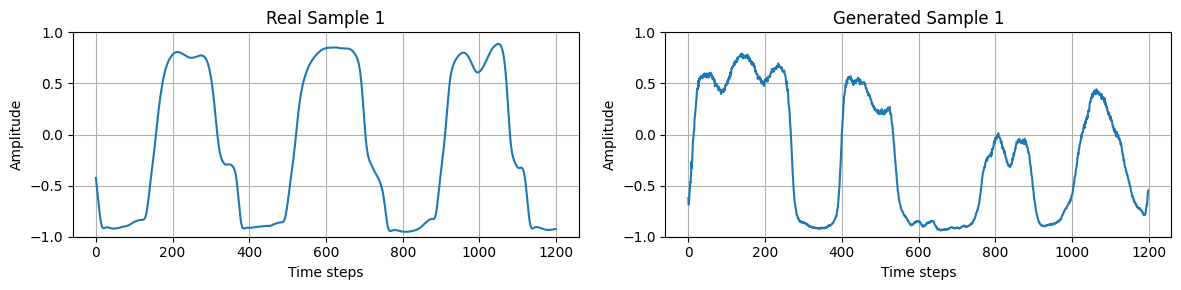

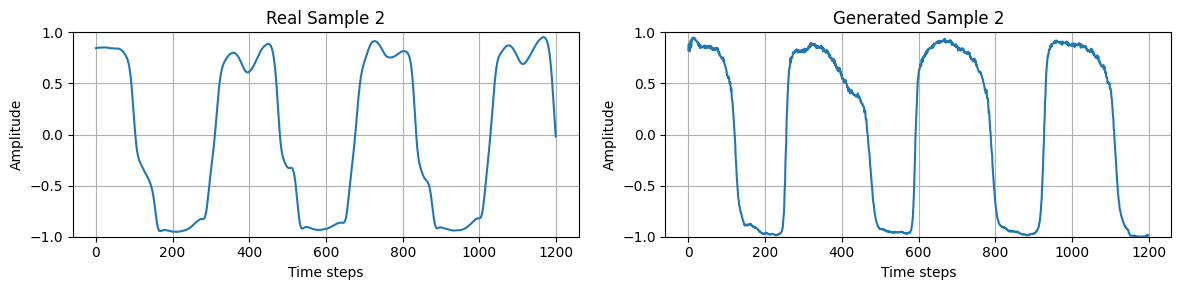

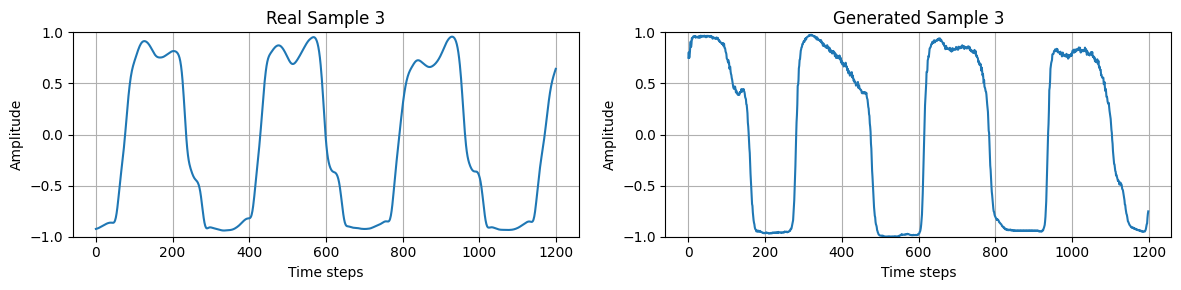

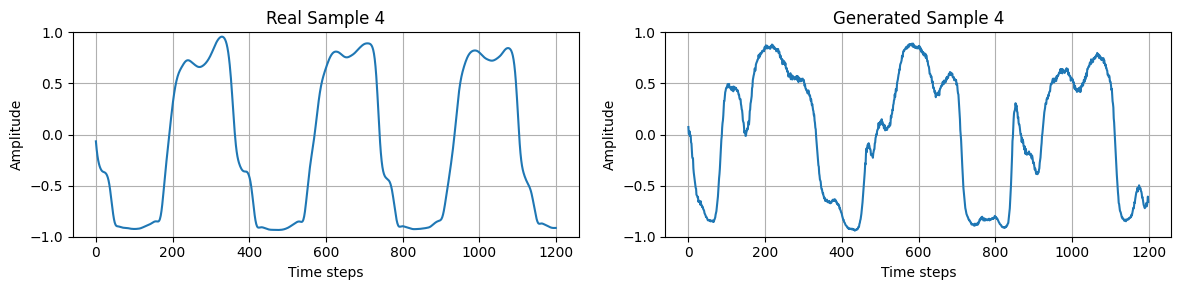

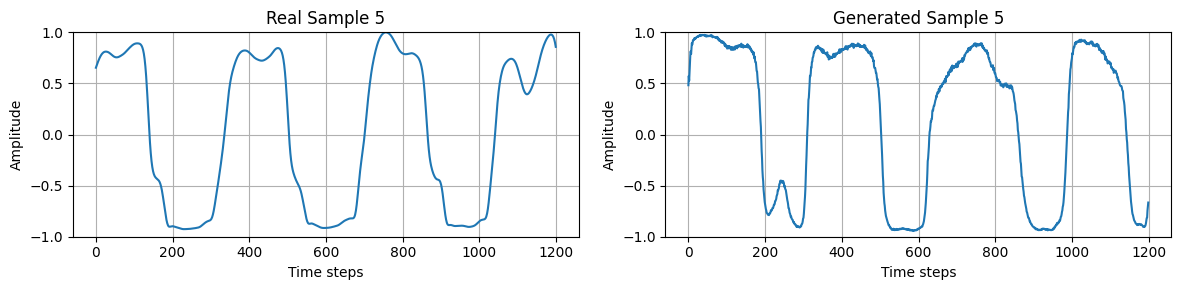

In [ ]:
# === Génération d'échantillons factices ===
generated_samples = generator(fixed_noise, training=False)

# === Comparaison entre 5 échantillons réels et générés ===
for i in range(5):
    plt.figure(figsize=(12, 3))

    # Réel
    plt.subplot(1, 2, 1)
    plt.plot(data[i, :, 0])
    plt.title(f"Real Sample {i+1}")
    plt.xlabel("Time steps")
    plt.ylabel("Amplitude")
    plt.ylim(-1, 1)
    plt.grid(True)

    # Généré
    plt.subplot(1, 2, 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f"Generated Sample {i+1}")
    plt.xlabel("Time steps")
    plt.ylabel("Amplitude")
    plt.ylim(-1, 1)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


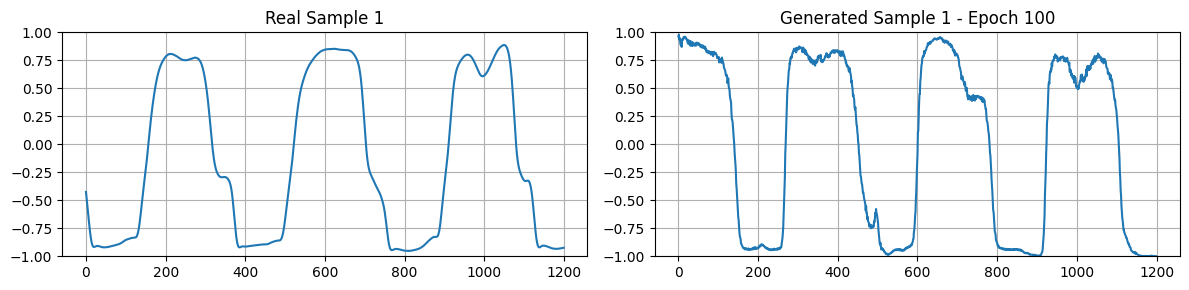

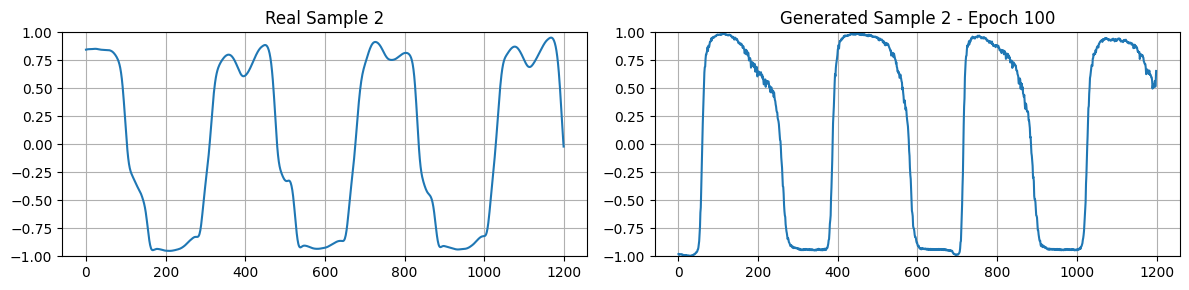

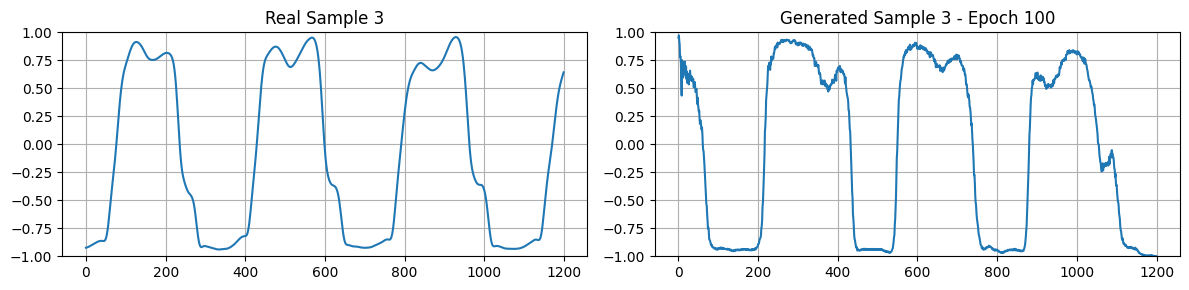

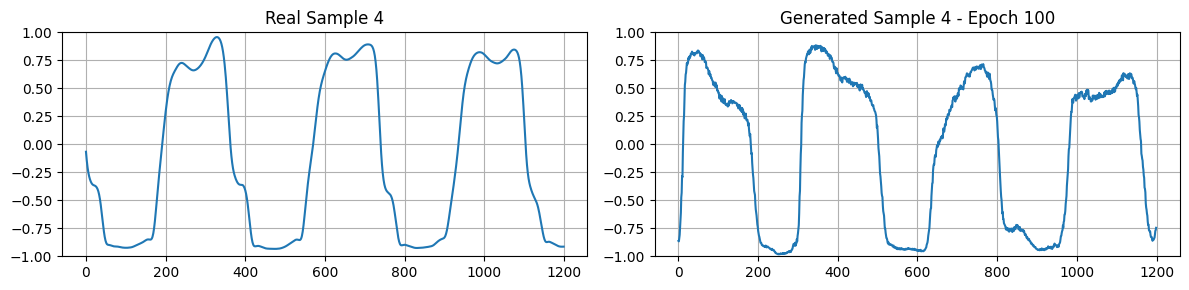

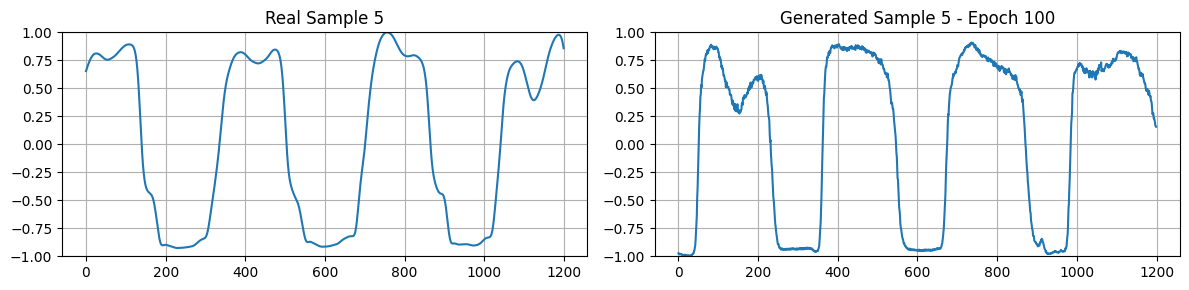

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
NOISE_DIM = 64
data_path = "/content/drive/MyDrive/hunt_left/hunt_all_left.npz"

# === Load data for comparison ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

# === Redefine the generator architecture ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# === Load generator weights from epoch 100 ===
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/hunt_left/saved_models_hunt_left/generator_epoch_100.weights.h5')

# === Generate fixed noise and generate samples ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False)

# === Plot real vs generated ===
for i in range(5):
    plt.figure(figsize=(12, 3))

    # Real sample
    plt.subplot(1, 2, 1)
    plt.plot(data[i, :, 0])
    plt.title(f"Real Sample {i+1}")
    plt.ylim(-1, 1)
    plt.grid(True)

    # Generated sample
    plt.subplot(1, 2, 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f"Generated Sample {i+1} - Epoch 100")
    plt.ylim(-1, 1)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📏 MMD Score: 0.020018780324496072
🔄 Average DTW Distance: 10.862171708142855
🔁 Average Cross-Correlation: 0.029683527010150916


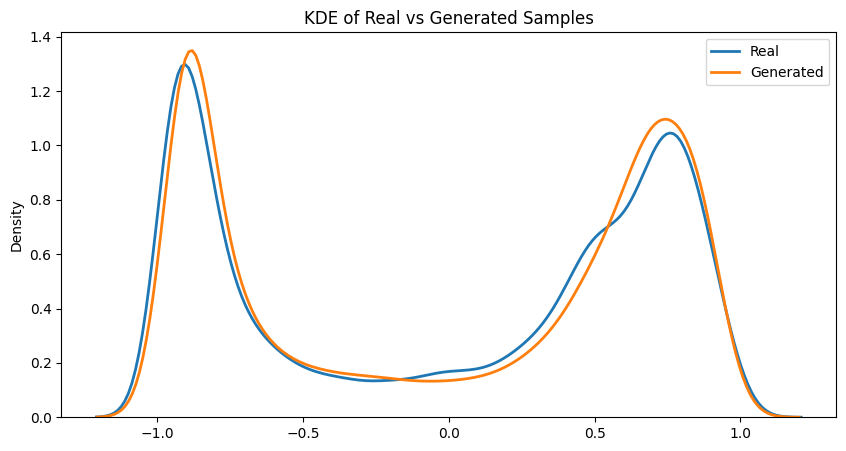

In [ ]:
!pip install dtaidistance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from dtaidistance import dtw
import seaborn as sns

# --- Paramètres ---
NOISE_DIM = 64
num_samples =100   # Nombre d'échantillons à comparer

# --- Chargement des données réelles ---
data_path = "/content/drive/MyDrive/hunt_left/hunt_all_left.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# --- Générateur ---
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# --- Chargement du générateur préentraîné ---
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/hunt_left/saved_models_hunt_left/generator_epoch_100.weights.h5')

# --- Génération des échantillons ---
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# --- MMD ---
def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

real_flat = real_samples.reshape(real_samples.shape[0], -1)
fake_flat = generated_samples.reshape(generated_samples.shape[0], -1)

mmd_score = compute_mmd(real_flat, fake_flat, gamma=0.1)
print("📏 MMD Score:", mmd_score)

# --- DTW ---
def compute_average_dtw(real_samples, generated_samples):
    dtw_distances = []
    for r, g in zip(real_samples, generated_samples):
        dist = dtw.distance(r.flatten(), g.flatten())
        dtw_distances.append(dist)
    return np.mean(dtw_distances)

dtw_score = compute_average_dtw(real_samples, generated_samples)
print("🔄 Average DTW Distance:", dtw_score)

# --- Cross-Correlation ---
def cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) + 1e-8)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)
    return np.correlate(a, b, mode='valid')[0] / len(a)

ccs = [cross_correlation(r.flatten(), g.flatten()) for r, g in zip(real_samples, generated_samples)]
print("🔁 Average Cross-Correlation:", np.mean(ccs))

# --- Visualisation KDE ---
plt.figure(figsize=(10, 5))
sns.kdeplot(real_samples.reshape(-1), label="Real", linewidth=2)
sns.kdeplot(generated_samples.reshape(-1), label="Generated", linewidth=2)
plt.legend()
plt.title("KDE of Real vs Generated Samples")
plt.show()